In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from bayesinsight import BayesInsightModel
import matplotlib.pyplot as plt
import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

/Users/redam94/Coding/Projects/BayesInsight/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Start by Loading a Dataset 
This is just a folder that contains the mff with the file name data.csv and a metadata json file
Running the following command 
```python
BayesInsightModel.new_from_dataset("path/to/data", output='model_name')
```
will create a template for you to use to build your model

In [4]:
BayesInsightModel.new_from_dataset("complex_model/data", output="example_model")

You should now have a folder called **example_model** in your local directory. Your data and metadata now lives in the **data** subdirectory. You also should see a file called **model_def.json**. This is where the model can be defined currently there is a placeholder that must be edited for the model to run.

**See the README for more detail**

For now, lets open up a model that was already setup it's in a folder called **complex_model**.
Take a look at the **model_def.json** file. 

***Hint** if you are using vscode you can right click in the file and select format document in the drop down to make the file more human readable*

You will see I have 3 variables defined in the variable details list. One control variable Promotions_Total_Total_Total, one media variable media_var_0_Total_Total_Total, and one exog variable Stock_Total_Total_Total.

Media variables are special they receive media transforms such as deminishing return curves and adstock.
Exog variables define the likelihood for the model and are similar to the dependent variables in an AWB model.
Control variables can be used to define other independant variables that are in the model.


Let's load up the model now!

In [14]:
my_model = BayesInsightModel.load("complex_model")

In [13]:
cProfile.run("BayesInsightModel.load('complex_model')", 'build_stats')

# Then analyze results
import pstats
p = pstats.Stats('build_stats')
p.sort_stats('cumtime').print_stats(10)

Wed Mar 19 23:20:29 2025    build_stats

         8846 function calls (8670 primitive calls) in 0.148 seconds

   Ordered by: cumulative time
   List reduced from 624 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.148    0.148 {built-in method builtins.exec}
        1    0.002    0.002    0.148    0.148 <string>:1(<module>)
        1    0.000    0.000    0.146    0.146 /Users/redam94/Coding/Projects/BayesInsight/bayesinsight/models/model.py:407(load)
        1    0.000    0.000    0.111    0.111 /Users/redam94/Coding/Projects/BayesInsight/bayesinsight/models/dataloading.py:249(from_bundle)
        1    0.000    0.000    0.110    0.110 /Users/redam94/Coding/Projects/BayesInsight/bayesinsight/models/dataloading.py:262(load_from_file)
        1    0.000    0.000    0.072    0.072 /Users/redam94/Coding/Projects/BayesInsight/.venv/lib/python3.11/site-packages/pandas/io/parsers/readers.py:868(read_csv)
 

## Now we just fit the model

In [17]:
import cProfile

cProfile.run('my_model.fit()')

# Then analyze results
import pstats
p = pstats.Stats('build_stats')
p.sort_stats('cumtime').print_stats(10)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_fixed_coeff, intercept_rand_coeff_sigma, intercept_rand_coeff, media_var_0_Total_Total_Total_fixed_coeff, media_var_0_Total_Total_Total_K_, media_var_0_Total_Total_Total_n_, media_var_0_Total_Total_Total_retention_rate_log, media_var_0_Total_Total_Total_lag, LLT_LLT::tau, LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas_sd, LLT_LLT::splines_betas, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Promotion_Total_Total_Total_rand_coeff, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff_sigma, annual_seasonality_0_rand_coeff, annual_seasonality_1_fixed_coeff, annual_seasonality_1_rand_coeff_sigma, annual_seasonality_1_rand_coeff, annual_seasonality_2_fixed_coeff, annual_seasonality_2_rand_coeff_sigma, annual_seasonality_2_rand_coeff, annual_seasonality_3_fixed_coeff, annual_seasonality_3_rand_coeff_sigma, annual_seasonality_3_rand_c

/Users/redam94/Coding/Projects/BayesInsight/.venv/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

         61914461 function calls (61411073 primitive calls) in 2298.592 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3750    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
     3765    0.002    0.000    0.003    0.000 <frozen _collections_abc>:693(remove)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:771(get)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:778(__contains__)
      385    0.000    0.000    0.000    0.000 <frozen _collections_abc>:786(keys)
    51954    0.013    0.000    0.019    0.000 <frozen _collections_abc>:790(items)
    14314    0.014    0.000    0.042    0.000 <frozen _collections_abc>:798(__eq__)
    52339    0.006    0.000    0.006    0.000 <frozen _collections_abc>:812(__init__)
      385    0.000    0.000    0.000    0.000 <frozen _collections_abc>:835(__iter__)
    53479    0.014    0.000    0.029    0.000 <

ValueError: Not enough samples to build a trace.

In [19]:
my_model.fit(draws=100, tune=100)  # We can change the sampler settings by passing arguments to fit
# e.g. my_model.fit(draws=2000, tune=1000, chains=4, overwrite=True) to run 4 chains
# of 2000 draws each with 1000 tuning steps and allow the model to overwrite the existing results
# this may take a while go grab a coffee

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_fixed_coeff, intercept_rand_coeff_sigma, intercept_rand_coeff, media_var_0_Total_Total_Total_fixed_coeff, media_var_0_Total_Total_Total_K_, media_var_0_Total_Total_Total_n_, media_var_0_Total_Total_Total_retention_rate_log, media_var_0_Total_Total_Total_lag, LLT_LLT::tau, LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas_sd, LLT_LLT::splines_betas, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Promotion_Total_Total_Total_rand_coeff, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff_sigma, annual_seasonality_0_rand_coeff, annual_seasonality_1_fixed_coeff, annual_seasonality_1_rand_coeff_sigma, annual_seasonality_1_rand_coeff, annual_seasonality_2_fixed_coeff, annual_seasonality_2_rand_coeff_sigma, annual_seasonality_2_rand_coeff, annual_seasonality_3_fixed_coeff, annual_seasonality_3_rand_coeff_sigma, annual_seasonality_3_rand_c

Output()

ValueError: Not enough samples to build a trace.

## Assuming that went well let's checkout how our model did

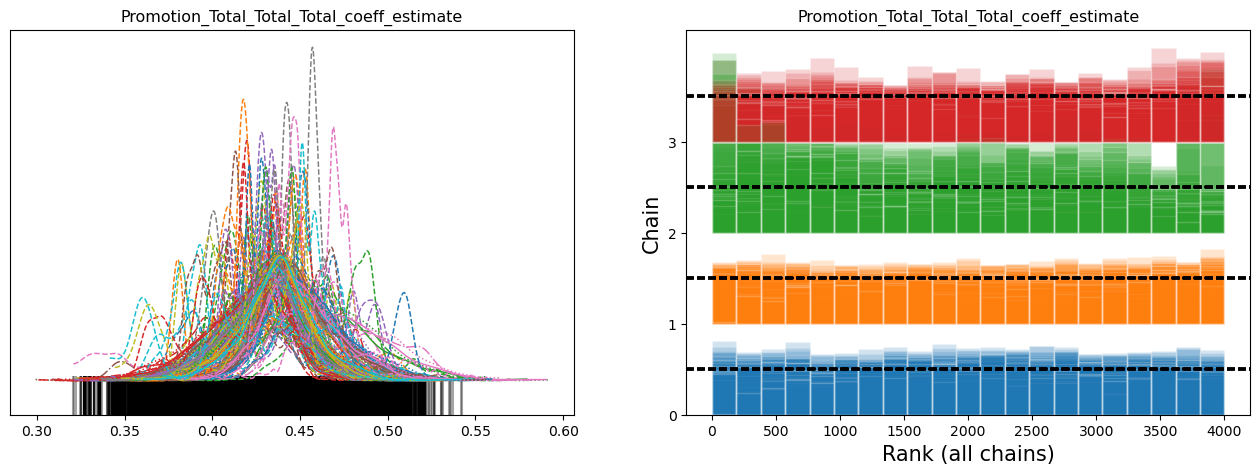

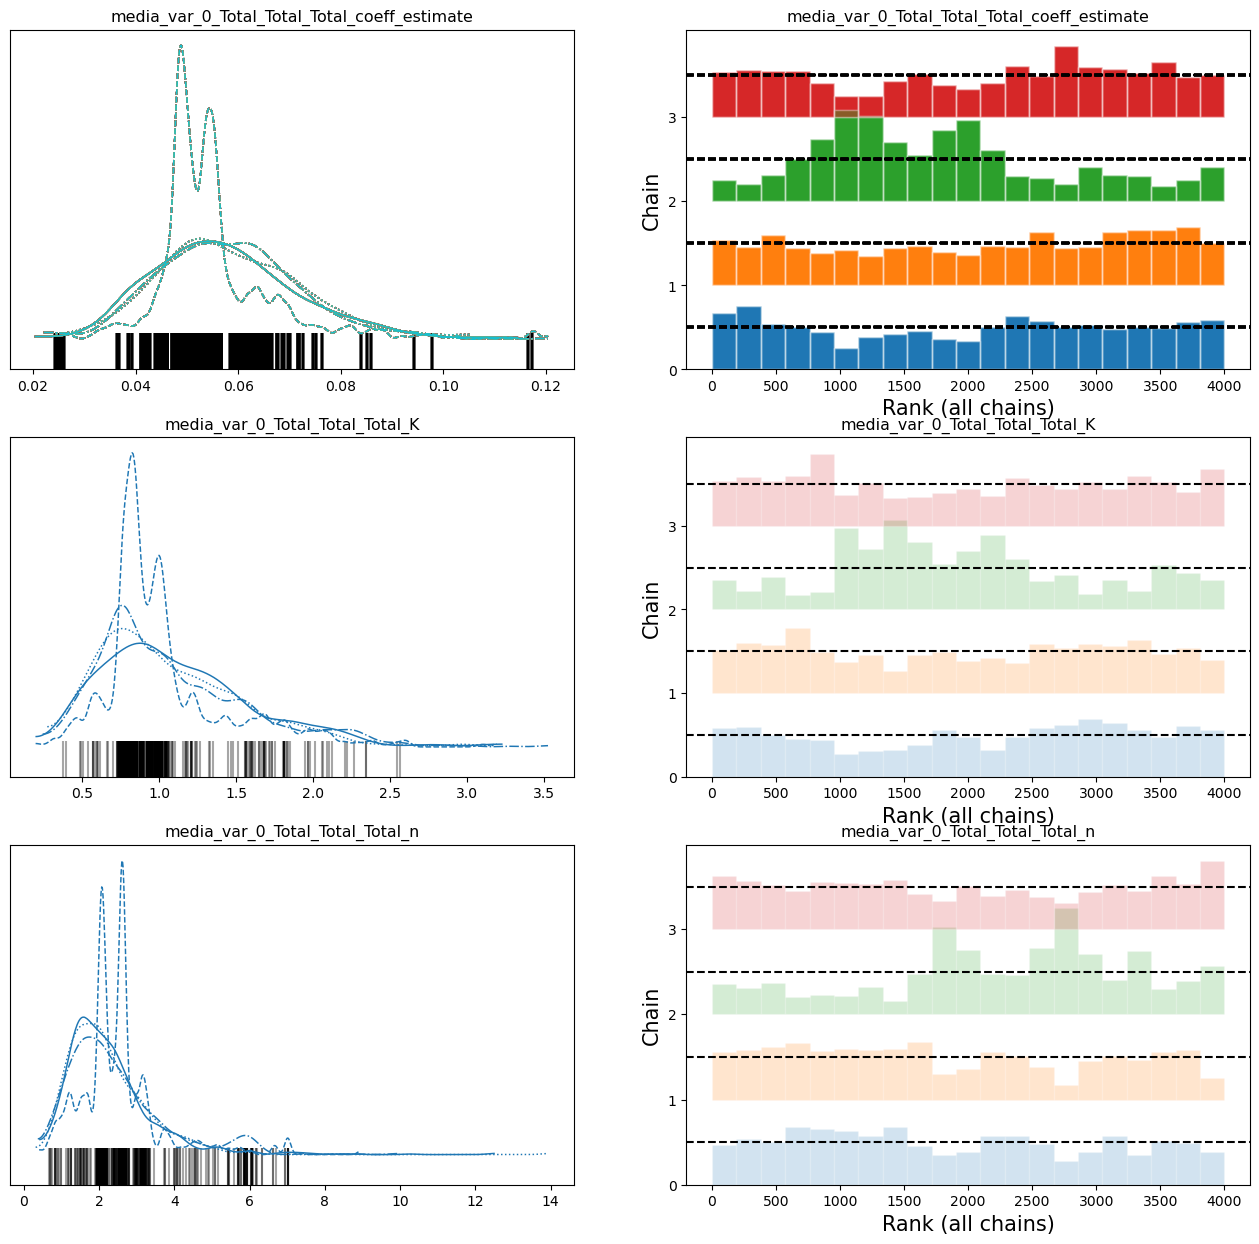

In [6]:
my_model.plot_posterior(
    varname=["Promotion_Total_Total_Total", "media_var_0_Total_Total_Total"]
);
# The plots on the left define the distribution of the parameters,
# while the plots on the right shows how well the sampler converged.
# The bars should be close to each other

['Geography', 'Product', 'Period']


/Users/mreda/Desktop/FootTrafficModel/foottraffic/awb_model/models/model.py:219: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior = pm.sample_posterior_predictive(self.trace)
Sampling: [Stock_Total_Total_Total_likelihood]


Output()

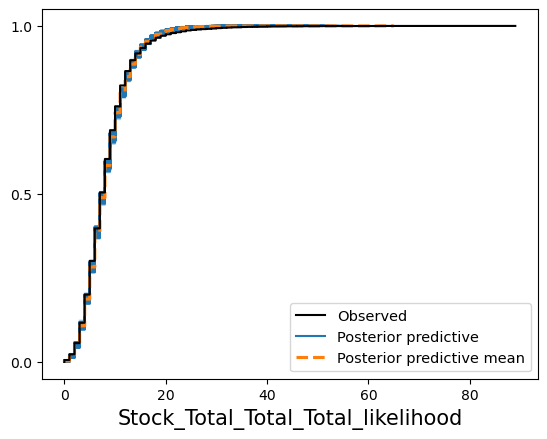

In [7]:
my_model.plot_posterior_predictive();  # This might take some time

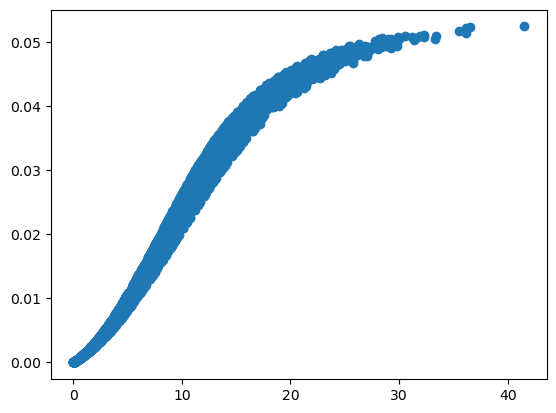

In [8]:
my_model.plot_posterior_curve("media_var_0_Total_Total_Total")

In [9]:
avm = my_model.avm()
avm.head()

['Geography', 'Product', 'Period']


/Users/mreda/Desktop/FootTrafficModel/foottraffic/awb_model/models/model.py:219: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior = pm.sample_posterior_predictive(self.trace)
Sampling: [Stock_Total_Total_Total_likelihood]


Output()

,Geography,Product,Period,Stock_Total_Total_Total,Stock_Total_Total_Total_likelihood,mu
0,AU,Desktops,2020-04-06,14.0,10.76275,10.776814
1,AU,Desktops,2020-04-13,5.0,10.10475,10.033402
2,AU,Desktops,2020-04-20,5.0,5.45525,5.386329
3,AU,Desktops,2020-04-27,6.0,6.25075,6.179820
4,AU,Desktops,2020-05-04,10.0,8.27875,8.232076


In [10]:
contributions = my_model.get_contributions()
contributions.head()

,Geography,Product,Period,intercept_contribution,Promotion_Total_Total_Total_contribution,media_var_0_Total_Total_Total_contribution
0,AU,Desktops,2020-04-06,2.03053,0.343454,0.003090
1,AU,Desktops,2020-04-13,2.03053,0.239370,0.035840
2,AU,Desktops,2020-04-20,2.03053,-0.354749,0.007704
3,AU,Desktops,2020-04-27,2.03053,-0.213245,0.003833
4,AU,Desktops,2020-05-04,2.03053,0.070162,0.007292


In [14]:
my_model.model_af().head()

,Geography,Product,Period,Promotion_Total_Total_Total,media_var_0_Total_Total_Total,Stock_Total_Total_Total
0,AU,Desktops,2020-04-06,1.041951,2.116320,14.0
1,AU,Desktops,2020-04-13,0.726187,14.524069,5.0
2,AU,Desktops,2020-04-20,-1.076217,4.238416,5.0
3,AU,Desktops,2020-04-27,-0.646932,2.504433,6.0
4,AU,Desktops,2020-05-04,0.212854,4.069366,10.0


In [28]:
contribution_actuals = contributions.merge(
    my_model.model_af(), on=my_model.data.metadata.row_ids
)

In [17]:
contribution_actuals.head()

,Geography,Product,Period,intercept_contribution,Promotion_Total_Total_Total_contribution,media_var_0_Total_Total_Total_contribution,Promotion_Total_Total_Total,media_var_0_Total_Total_Total,Stock_Total_Total_Total
0,AU,Desktops,2020-04-06,2.03053,0.343454,0.003090,1.041951,2.116320,14.0
1,AU,Desktops,2020-04-13,2.03053,0.239370,0.035840,0.726187,14.524069,5.0
2,AU,Desktops,2020-04-20,2.03053,-0.354749,0.007704,-1.076217,4.238416,5.0
3,AU,Desktops,2020-04-27,2.03053,-0.213245,0.003833,-0.646932,2.504433,6.0
4,AU,Desktops,2020-05-04,2.03053,0.070162,0.007292,0.212854,4.069366,10.0


In [20]:
from itertools import product

In [31]:
sorted(
    tuple(contribution_actuals[id_].unique() for id_ in ["Geography", "Product"]),
    key=len,
    reverse=True,
)

[array(['AU', 'BR', 'CA', 'DE', 'FR', 'JP', 'KR', 'MX', 'UK', 'US'],
       dtype=object),
 array(['Desktops', 'Laptops', 'Phones', 'Tablets', 'Watches'],
       dtype=object)]

In [64]:
def plot_contributions_vs_actuals(model):
    contribution_actuals = model.get_contributions().merge(
        model.model_af(), on=model.data.metadata.row_ids
    )
    pairs = [
        (col, col.replace("_contribution", ""))
        for col in contribution_actuals.columns
        if "_contribution" in col and "intercept" not in col
    ]
    row_id = [row for row in model.data.metadata.row_ids if row != "Period"]
    unique_values = tuple(contribution_actuals[id_].unique() for id_ in row_id)
    lens = [len(values) for values in unique_values]

    for pair in pairs:
        fig, axs = plt.subplots(*lens, figsize=(20, 20), layout="constrained")
        for i, values in enumerate(product(*unique_values)):
            data = contribution_actuals
            for id_, value in zip(row_id, values):
                data = data[data[id_] == value]
            ax = axs.flatten()[i]
            ax.scatter(
                contribution_actuals[pair[1]],
                contribution_actuals[pair[0]],
                color="gray",
                alpha=0.05,
                s=2,
            )
            ax.scatter(data[pair[1]], data[pair[0]], color="blue", s=2)
            ax.set_xlabel(pair[1])
            ax.set_ylabel("Contribution")
            ax.set_title(" x ".join(values))
        plt.suptitle(f"{pair[1]} vs Contribution")
        # ax.set_title(", ".join(f"{id_}: {value}" for id_, value in zip(row_id, values)))
        # ax.plot(data[pair[1]], data[pair[1]], color="red")
        # plt.tight_layout()
        plt.show()

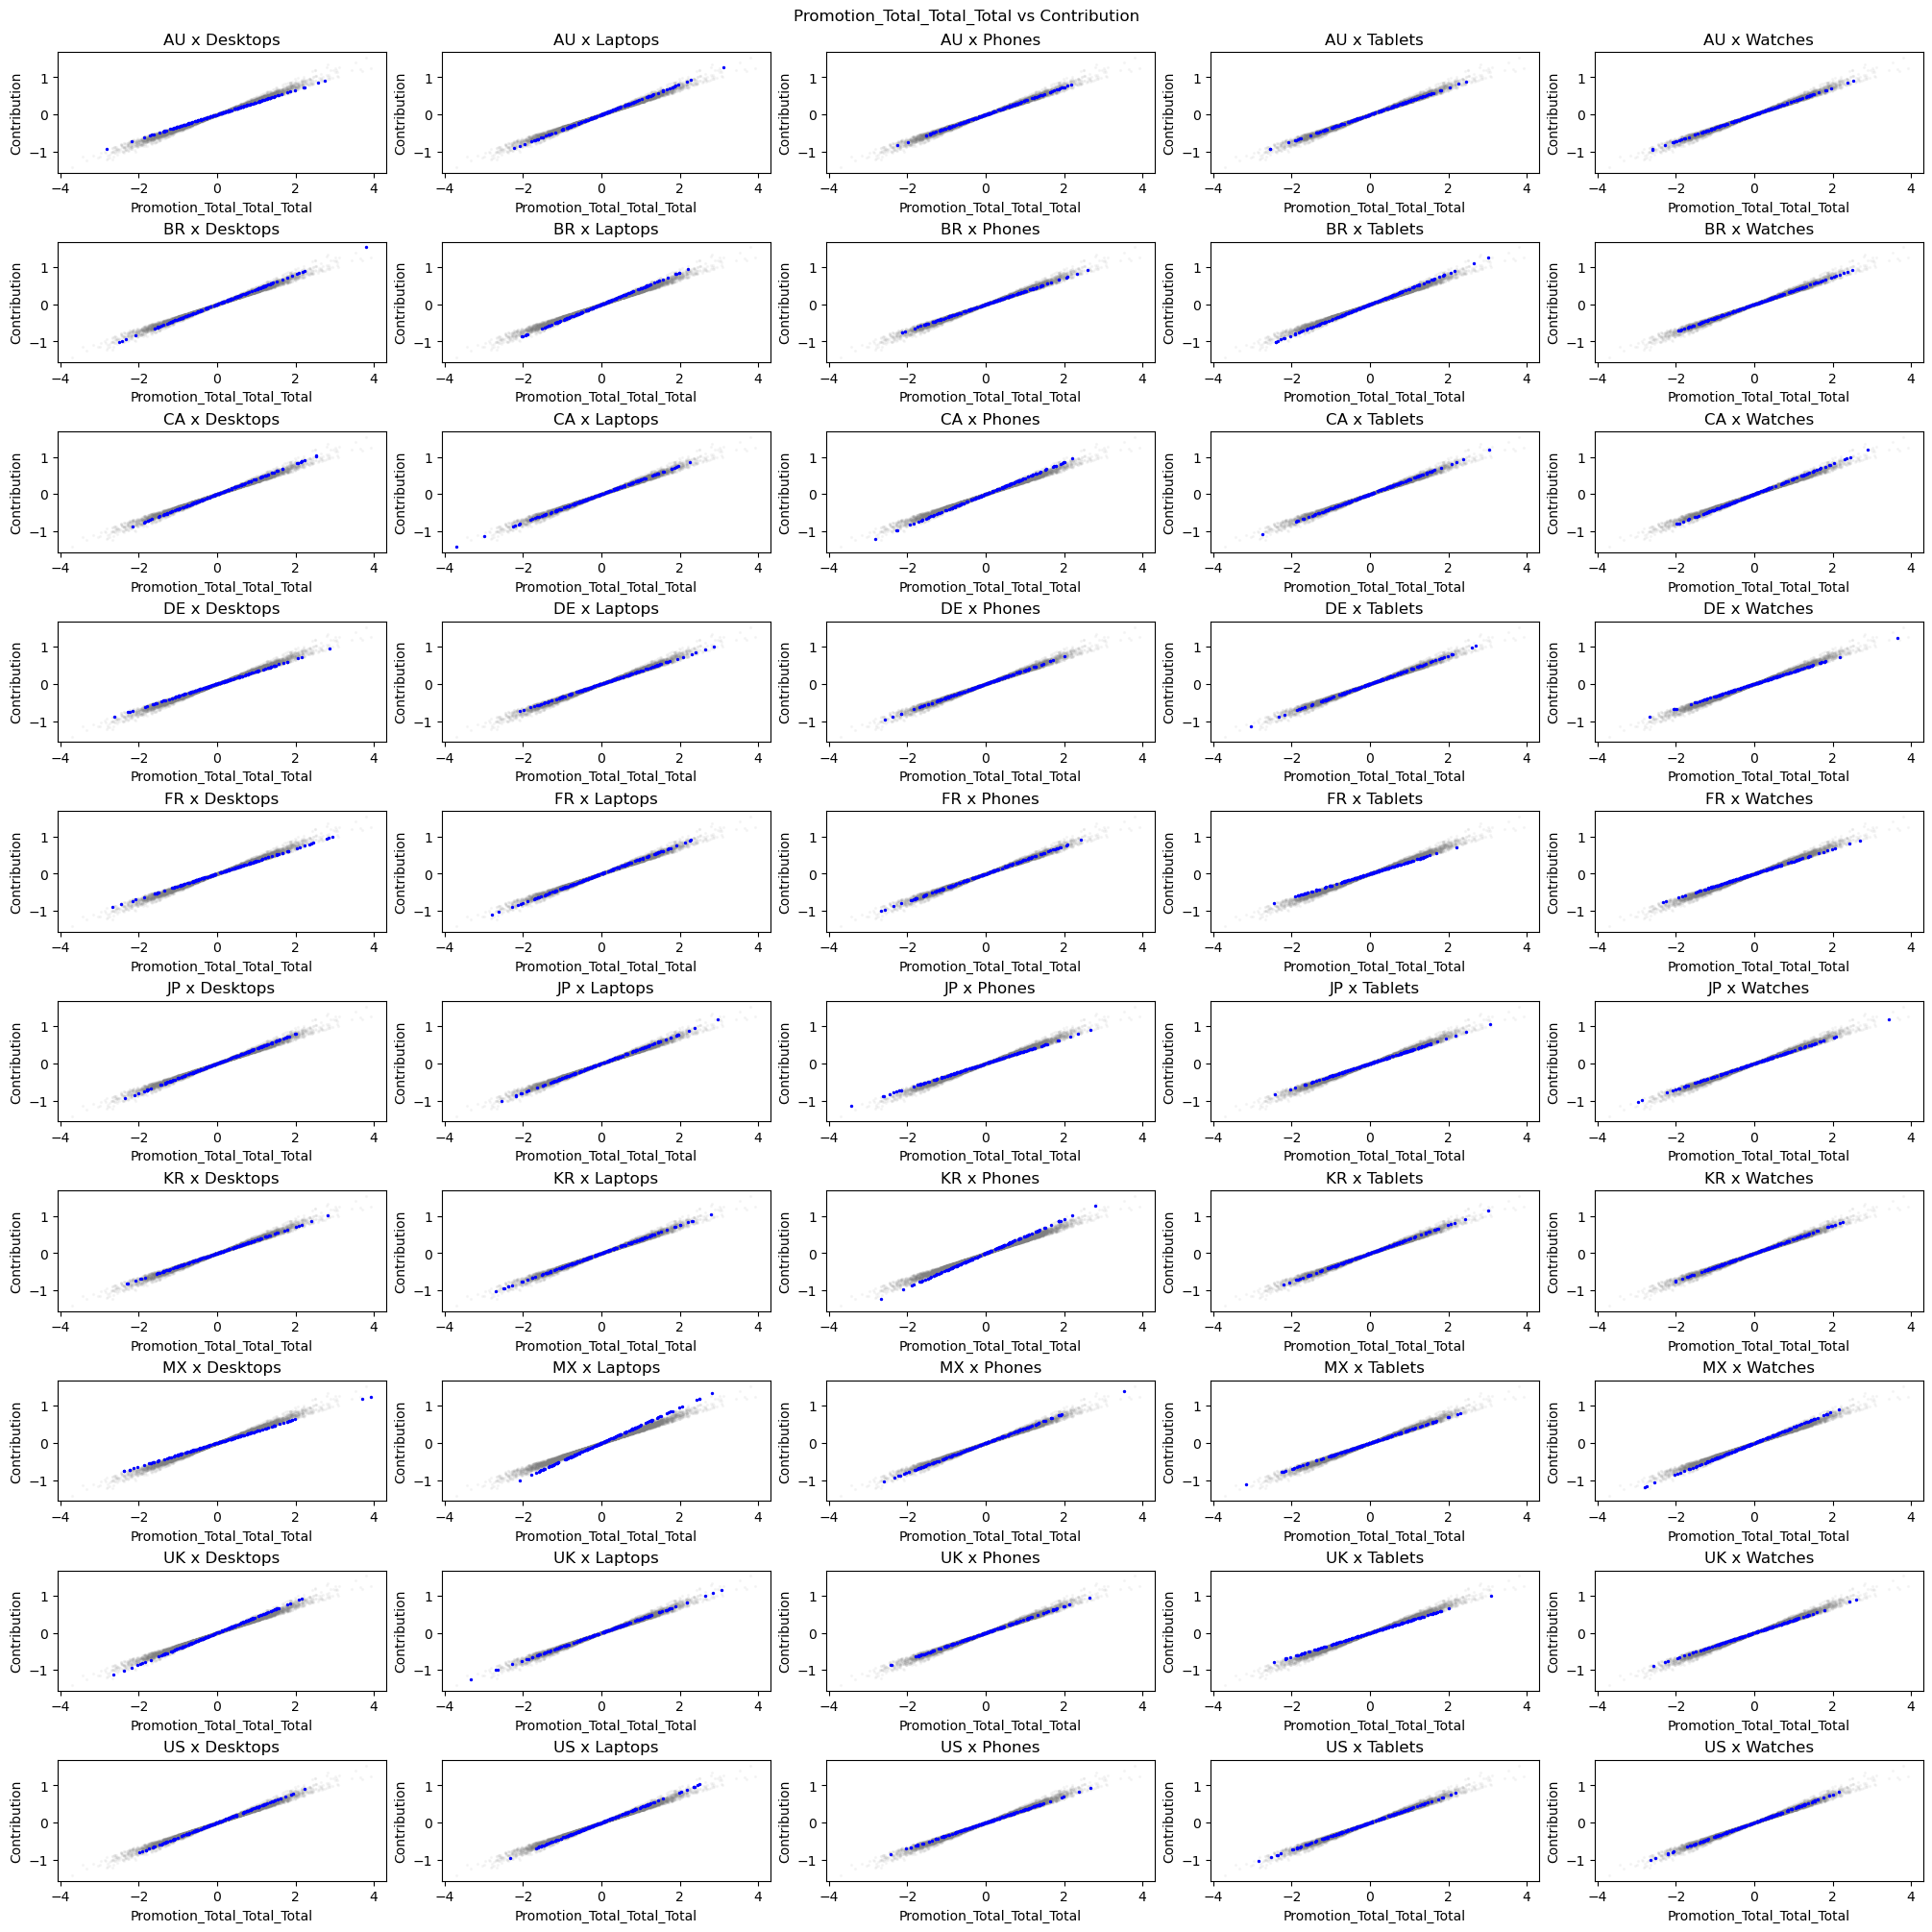

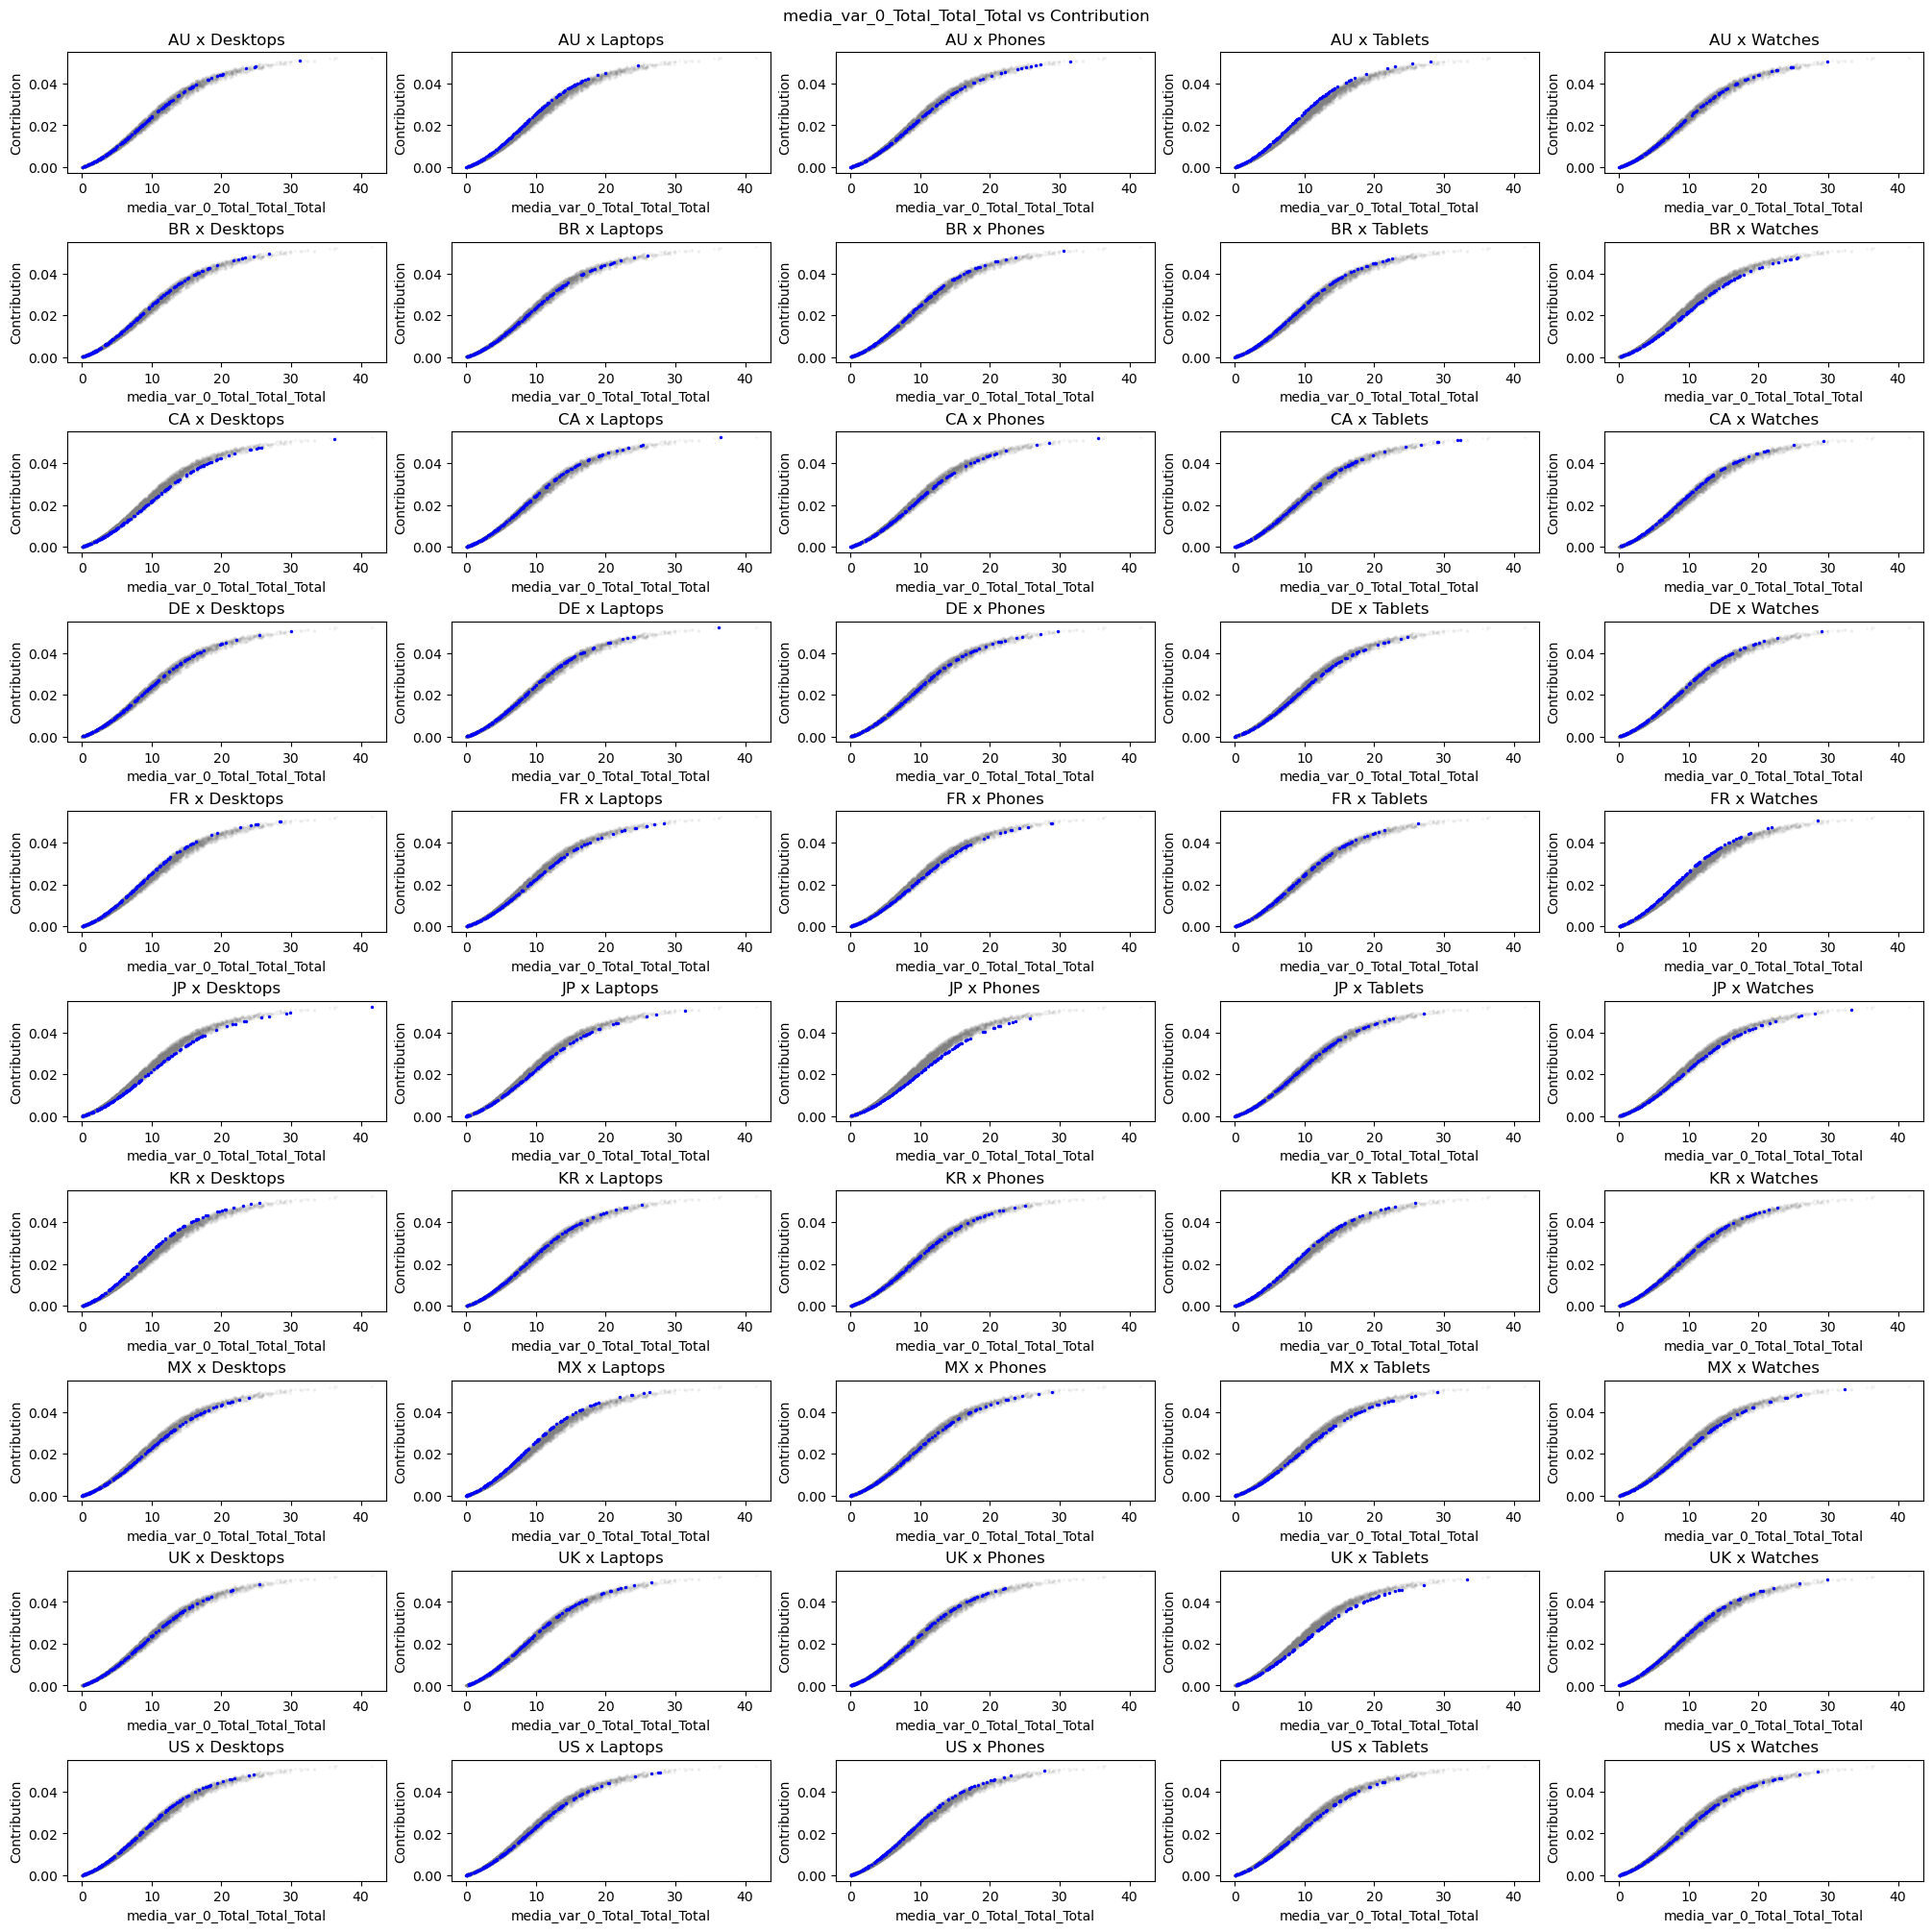

In [65]:
plot_contributions_vs_actuals(my_model)

## You can also directly examine the trace to further examine the posterior

In [17]:
my_model.trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

## Finally you can save the model

In [16]:
my_model.save("final_model")

/Users/mreda/miniconda3/envs/foottraffic/lib/python3.11/site-packages/pydantic/main.py:352: UserWarning: Pydantic serializer warnings:
  Expected `tuple[literal['Geography','Period','Product','Outlet','Campaign','Creative'], ...]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(
